In [25]:
!pip install --upgrade google-cloud
!pip install --upgrade google-auth


In [26]:
# Install necessary libraries
!pip install --quiet web3 google-cloud-bigquery gspread oauth2client matplotlib pandas solana


In [27]:
# Authenticate your Google Account to use BigQuery
from google.colab import auth
auth.authenticate_user()

print("✅ Google Cloud Authentication successful!")


✅ Google Cloud Authentication successful!


In [2]:
from google.colab import files
uploaded = files.upload()


Saving dataset-hackathon.json to dataset-hackathon.json


In [9]:
query = f"""
SELECT
  block_timestamp,
  from_address,
  to_address,
  CAST(value AS FLOAT64) / 1e6 AS pyusd_amount
FROM `bigquery-public-data.crypto_ethereum.token_transfers`
WHERE token_address = '{pyusd_token_address}'
  AND block_timestamp >= TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 7 DAY)
ORDER BY block_timestamp DESC
LIMIT 100
"""

# Run the query
pyusd_df = client.query(query).to_dataframe()

# Show the result
print("✅ PYUSD transactions (last 7 days):")
pyusd_df.head()


✅ PYUSD transactions (last 7 days):


,block_timestamp,from_address,to_address,pyusd_amount
0,2025-04-12 12:01:23+00:00,0x264bd8291fae1d75db2c5f573b07faa6715997b5,0x0860cc9bb6d8d373a8727834dd6f755436753ecf,30.0
1,2025-04-12 12:00:59+00:00,0x264bd8291fae1d75db2c5f573b07faa6715997b5,0x0860cc9bb6d8d373a8727834dd6f755436753ecf,30.0
2,2025-04-12 12:00:47+00:00,0x264bd8291fae1d75db2c5f573b07faa6715997b5,0x0860cc9bb6d8d373a8727834dd6f755436753ecf,30.0
3,2025-04-12 12:00:35+00:00,0x264bd8291fae1d75db2c5f573b07faa6715997b5,0x0860cc9bb6d8d373a8727834dd6f755436753ecf,20.0
4,2025-04-12 12:00:23+00:00,0x264bd8291fae1d75db2c5f573b07faa6715997b5,0x0860cc9bb6d8d373a8727834dd6f755436753ecf,20.0


In [10]:
# Group by day and sum
pyusd_df['block_date'] = pyusd_df['block_timestamp'].dt.date
daily_volume = pyusd_df.groupby('block_date')['pyusd_amount'].sum().reset_index()

# Most active sender/receiver
top_senders = pyusd_df.groupby('from_address')['pyusd_amount'].sum().sort_values(ascending=False).head(10)
top_receivers = pyusd_df.groupby('to_address')['pyusd_amount'].sum().sort_values(ascending=False).head(10)

print("📊 Daily Transaction Volume:")
print(daily_volume)

print("\n🔥 Top 10 Senders:")
print(top_senders)

print("\n🚀 Top 10 Receivers:")
print(top_receivers)


📊 Daily Transaction Volume:
   block_date  pyusd_amount
0  2025-04-12  7.681570e+06

🔥 Top 10 Senders:
from_address
0x14768308d93b19ffc57cc9531cc011a7ae3d6328    1.834407e+06
0x51c72848c68a965f66fa7a88855f9f7784502a7f    1.652942e+06
0x81ebde24453b8e40454616579ea79c79a197699d    1.596638e+06
0x9008d19f58aabd9ed0d60971565aa8510560ab41    1.596626e+06
0x688e72142674041f8f6af4c808a4045ca1d6ac82    9.801711e+05
0x264bd8291fae1d75db2c5f573b07faa6715997b5    7.583426e+03
0x74f047e3967c26fe1aeb7a78d5a8302a0312fedf    4.999920e+03
0x3a09c40f8f7b93c8c7e09a5422e56dfe7c7d2794    3.387668e+03
0x1f281de34148d4ab3751228a6ee0352a4c20e32f    2.831630e+03
0xa802d0be4037bec0a9bf4d69d5805727c28e3bad    5.201977e+02
Name: pyusd_amount, dtype: float64

🚀 Top 10 Receivers:
to_address
0x264bd8291fae1d75db2c5f573b07faa6715997b5    1.837795e+06
0x14768308d93b19ffc57cc9531cc011a7ae3d6328    1.652942e+06
0x9008d19f58aabd9ed0d60971565aa8510560ab41    1.596638e+06
0x51c72848c68a965f66fa7a88855f9f7784502a7f    1.59

<ipython-input-11-bd94ba96fbe5>:12: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


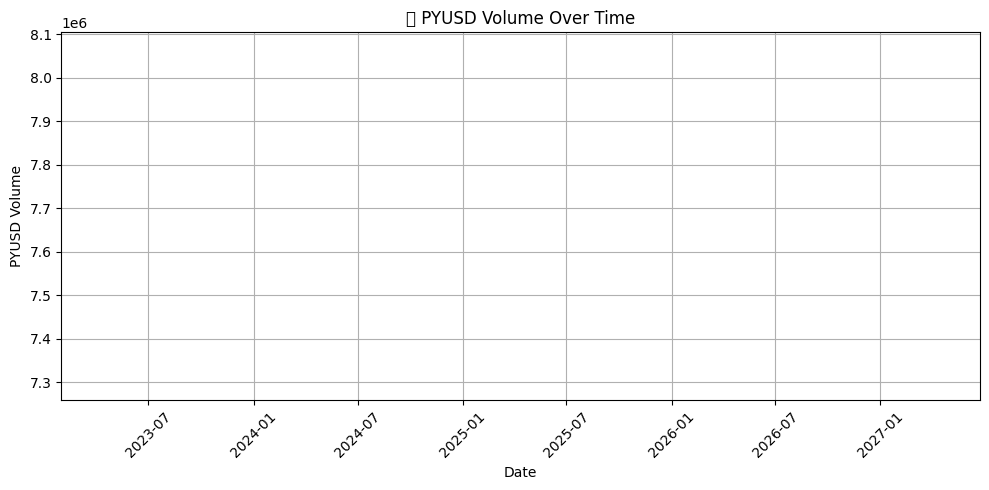

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Line plot for volume
plt.figure(figsize=(10,5))
sns.lineplot(data=daily_volume, x='block_date', y='pyusd_amount')
plt.title("📈 PYUSD Volume Over Time")
plt.xlabel("Date")
plt.ylabel("PYUSD Volume")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-14-1a6c3ef5e0b5>:35: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


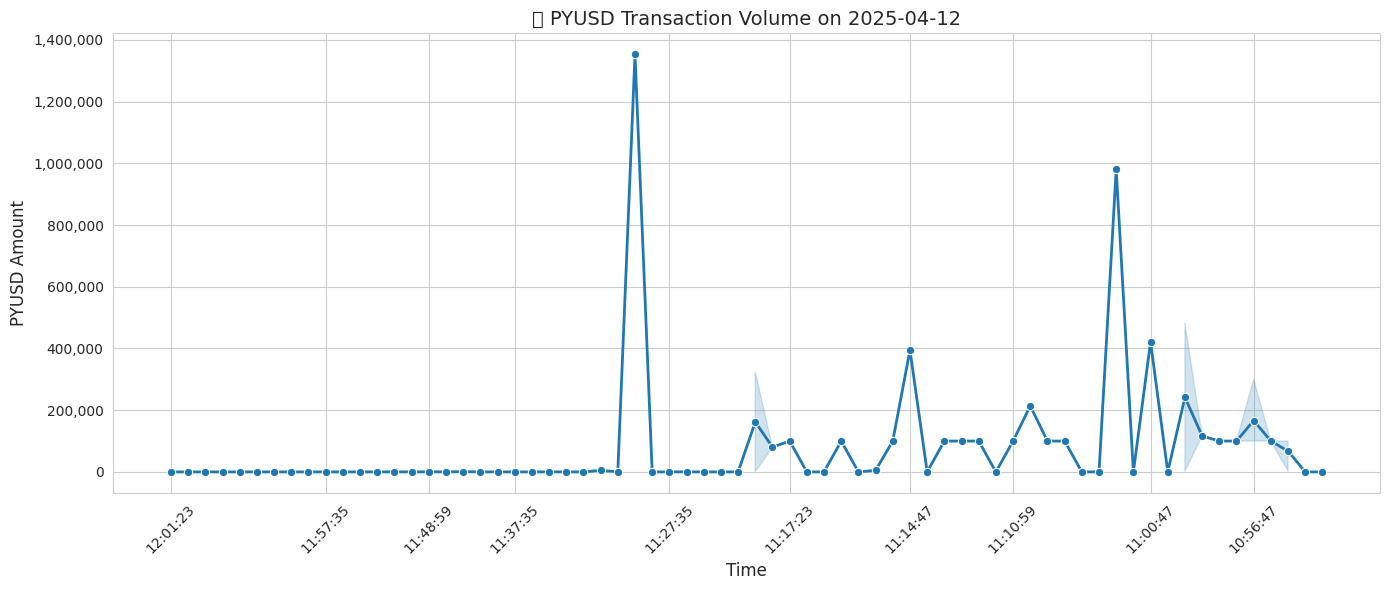

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Make sure datetime is parsed correctly
pyusd_df['block_timestamp'] = pd.to_datetime(pyusd_df['block_timestamp'])

# Create a new column for time (HH:MM:SS) for clearer x-axis
pyusd_df['time_only'] = pyusd_df['block_timestamp'].dt.strftime('%H:%M:%S')

# Set the style for seaborn
sns.set_style("whitegrid")

# Plot directly without resampling (since it's only one day)
plt.figure(figsize=(14, 6))
sns.lineplot(data=pyusd_df, x='time_only', y='pyusd_amount', marker='o', linewidth=2)

plt.title("📈 PYUSD Transaction Volume on 2025-04-12", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("PYUSD Amount", fontsize=12)

# Use every 10th label to avoid x-axis clutter
plt.xticks(rotation=45, ticks=pyusd_df['time_only'][::10])

# Add thousand separator for readability
from matplotlib.ticker import FuncFormatter
formatter = FuncFormatter(lambda x, _: f'{int(x):,}')
plt.gca().yaxis.set_major_formatter(formatter)

# Optional: Annotate high value transfers above 1 million
# for x, y in zip(pyusd_df['time_only'], pyusd_df['pyusd_amount']):
#     if y > 1_000_000:
#         plt.text(x, y, f'{int(y):,}', color='red', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.grid(True)
plt.show()


In [15]:
!pip install --upgrade gspread gspread_dataframe


In [21]:
import gspread
from gspread_dataframe import set_with_dataframe
from google.oauth2.service_account import Credentials

# Define scopes to allow full access to Google Sheets and Drive
scope = [
    "https://www.googleapis.com/auth/spreadsheets",
    "https://www.googleapis.com/auth/drive"
]

# Load credentials and authorize the client
creds = Credentials.from_service_account_file("dataset-hackathon.json", scopes=scope)
client = gspread.authorize(creds)

# Create a new sheet
sheet = client.create("PYUSD Transaction Log")  # Creates a new Sheet
worksheet = sheet.get_worksheet(0)

# Push dataframe to sheet
set_with_dataframe(worksheet, pyusd_df)

# Print the URL of the newly created sheet
print(f"✅ Sheet created: https://docs.google.com/spreadsheets/d/{sheet.id}")


✅ Sheet created: https://docs.google.com/spreadsheets/d/1o8rCGqHT9ynTIVDBtjRZkOwSKXyDijNNjb3aFWlcB40


In [24]:


from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

# Build the Drive API client
service = build('drive', 'v3', credentials=creds)

# Grant access to the service account
file_id = '1o8rCGqHT9ynTIVDBtjRZkOwSKXyDijNNjb3aFWlcB40'  # The ID of the sheet created
user_email = 'ayobami732000@gmail.com'  # Your email address

# Choose the role you want to assign: 'owner' or 'writer'
role = 'writer'  # Change this to 'owner' if you want to give ownership

# Make the API request to share the file with your email
try:
    permission = service.permissions().create(
        fileId=file_id,
        body={'type': 'user', 'role': role, 'emailAddress': user_email},
        fields='id'
    ).execute()
    print(f"Access granted to {user_email} with {role} permissions")
except HttpError as error:
    print(f"An error occurred: {error}")


Access granted to ayobami732000@gmail.com with writer permissions
